In [1]:
from IPython.core import display
from io import BytesIO
import Image
import numpy as np
import random
from sklearn import svm
from scipy import spatial
import matplotlib as plot

def display_pil_image(im):
    """displayhook function for PIL Images, rendered as PNG"""
    b = BytesIO()
    im.save(b, format='png')
    data = b.getvalue()

    ip_img = display.Image(data=data, format='png', embed=True)
    return ip_img._repr_png_()

# register display func with PNG formatter:
png_formatter = get_ipython().display_formatter.formatters['image/png']
png_formatter.for_type(Image.Image, display_pil_image)


f = open('/Users/allenj12/Desktop/combined.txt')
lines = f.readlines()
f.close

images = []
for line in lines:
    nums = line.split()
    images.append([float(nums[0])] + [((float (val) + 1) * 128) for val in nums[1:]])

x1 = []
y1 = []
xelse = []
yelse = []
train = []
target = []

def symetry_intensity (img):

    sym = 0
    for i in range(len(img)/2):
        row = i/16
        col = 16 - (i % 16)
        
        com = 256 - (16 * row) - col
        
        
        sym += abs(img[i] - img[com])
    
    mean = ((sum(img)/len(img))/128) - 1
    sym = (sym/16384) - 1
    
    if img[0] == 1.0:
        x1.append(mean)
        y1.append(sym)
        #train.append([mean, sym])
        #target.append(1)
        
    if  not (img[0] == 1.0):
        xelse.append(mean)
        yelse.append(sym)
        #train.append([mean, sym])
        #target.append(-1)

for y in images:
    symetry_intensity(y)
    

rx1 = []
ry1 = []
rxelse = []
ryelse = []
training = [0]
eighthAnswers = []
trainyans = [0]



def pickRandom():
    

    ones = [[1, x1[n], y1[n]] for n in range(len(x1))]
    notOnes = [[-1, xelse[n], yelse[n]] for n in range(len(xelse))]
    Dtest = ones + notOnes
    
    for i in range(250):
        random.shuffle(Dtest)
        
        if Dtest[0][0] == 1:
            rx1.append(Dtest[0][1])
            ry1.append(Dtest[0][2])
            training.append([Dtest[0][1], Dtest[0][2]])
            trainyans.append(1)
            eighthAnswers.append(Dtest[0][0])
        else:
            rxelse.append(Dtest[0][1])
            ryelse.append(Dtest[0][2])
            training.append([Dtest[0][1], Dtest[0][2]])
            trainyans.append(-1)
            eighthAnswers.append(Dtest[0][0])
        
        Dtest.pop(0)
        
    return Dtest

eout = []
           
Dtest = pickRandom()

testyans = [x[0] for x in Dtest]
Dtest = [[x[1],x[2]] for x in Dtest]


In [2]:
import math

def makeWeights(init, layers):
    weights = [0]
    
    if init == "rand":
        for i in range(len(layers) - 1):
            if i == len(layers) - 2:
                weights.append(np.array([random.uniform(0, 1) for x in range((layers[i] * layers[i + 1]))]).reshape(layers[i], layers[i + 1]))
            else:
                weights.append(np.array([random.uniform(0, 1) for x in range((layers[i] * (layers[i + 1] - 1)))]).reshape(layers[i], (layers[i + 1] - 1)))
        return weights
    
    else:
        for i in range(len(layers) - 1):
            if i == len(layers) - 2:
                weights.append(np.array([init] * (layers[i] * layers[i + 1])).reshape(layers[i], layers[i + 1]))
            else:
                weights.append(np.array([init] * (layers[i] * (layers[i + 1] - 1))).reshape(layers[i], (layers[i + 1] - 1)))
        return weights
    
            
def forwardProp(x0, weights):
    xl = [np.array(x0)]
    for l in range(1,len(weights)):
        sl = weights[l].T.dot(xl[-1])
        xl.append(np.append(1,np.tanh(sl)))
        
    xl[-1] = xl[-1][1:][0]
    return xl

def classify(x0, weights):
    xl = [np.array(x0)]
    for l in range(1,len(weights)):
        sl = weights[l].T.dot(xl[-1])
        xl.append(np.append(1,np.tanh(sl)))
    return sign(xl[-1][1])
    

def backProp(xl, weights):
    dl = [np.array(1 - xl[-1] ** 2)]
    for l in reversed(range(1, len(weights) - 1)):
        diag = 1 - xl[l] ** 2
        tl = np.diagflat(diag[1:])
        
        product = weights[l + 1].dot(dl[0])
        dl[0:0] = [tl.dot(product[1:])]
    dl [0:0] = [0]
    return dl


def gradient(data, y, layers, weights):
    
    Ein = 0
    gl = [0] * len(weights)
    
    for i in range(1,len(data)):
        x0 = data[i]
        xl = forwardProp(x0, weights)
        for x in range(len(xl) - 1):
            xl[x] = np.array([[d] for d in xl[x]])
        dl = backProp(xl, weights)
        Ein += (1.0 / (4 * (len(data) - 1))) * ((xl[-1] - y[i]) ** 2)

        for l in range(1,len(weights)):
            glxn = (2 * (xl[-1] - y[i])) * (xl[l - 1].dot(dl[l].T)) #+ (0.01 / len(data))
            gl[l] = gl[l] + (1.0 / (len(data) - 1)) * (glxn / (len(data) - 1))
            
    return [gl, Ein]

def stochastic(data, y, layers, weights):
    
    alleins = []
    minChange = 1
    minEin = .0000000000000000000005
    maxIter = 1000000
    learningRate = .01
    
    Es = []
    
    iterr = 0
    Ein = 0
    change = 10
    
    for i in range(1, len(data)):
        data[i][0:0] = [1]
    
    while (iterr < maxIter) and (not((change <= minChange) and (Ein <= minEin))):
        ind = randint(1,len(data))
        point = [data[ind]]
        ans = [y[ind]]
        point[0:0] = [0]
        ans[0:0] = [0]
        gl,Ein = gradient(point, ans, layers, weights)
        alleins.append(Ein)
            
        change =  0
        for l in range(1, len(weights)):
            temp = np.sum(weights[l])
            weights[l] -= learningRate * gl[l]
            change += abs(temp - np.sum(weights[l]))
            
        iterr += 1
    print iterr
    return [weights,alleins]

layers = [3, 10, 1]
#print stochastic([0, [1, 1]], [0, 1], layers, makeWeights(.25, layers))
weights,eins = stochastic(training, trainyans, layers, makeWeights("rand", layers))

129717


129717


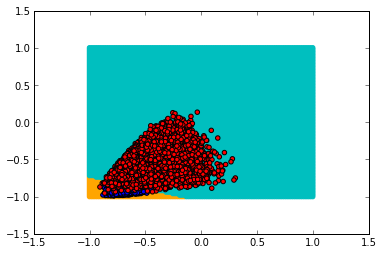

In [6]:
xspace = np.linspace(-1.0,1.0,100)
yspace = np.linspace(-1.0,1.0,100)
all_points_test = [[1,x,y] for x in xspace for y in yspace]
all_points = [[x,y] for x in xspace for y in yspace]

all_pos = []
all_neg = []
        
for i in range(len(all_points)):
    if classify(all_points_test[i], weights) == 1:
        all_pos.append(all_points[i])
    else:
        all_neg.append(all_points[i])
        
scatter(zip(*all_pos)[0], zip(*all_pos)[1], marker='o', color='orange')
scatter(zip(*all_neg)[0], zip(*all_neg)[1], marker='o', color='c')
scatter(x1,y1,marker = 'o',c = 'b',label='1')
scatter(xelse,yelse,marker = 'o',c = 'r',label='5')

print(len(eins))

In [4]:
def Etest(weights, train, trainyans, test, testyans):
    
    count = 0.0
    
    for i in range(len(test)):
        n = [1] + Dtest[i]
        
        summ = 0
        if (classify(n, weights) == 1) and (testyans[i] == -1):
            count += 1.0
            
        if (classify(n, weights) == -1) and (testyans[i] == 1):
            count += 1.0
                   
    return count / len(test)


print Etest(weights, training, trainyans, Dtest, testyans)
print 1 - Etest(weights, training, trainyans, Dtest, testyans)

0.013483642794
0.986516357206


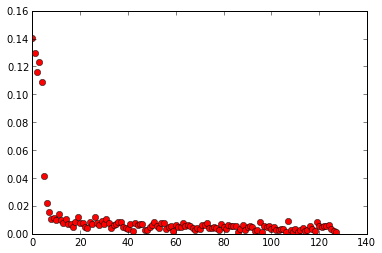

In [5]:
import matplotlib.pyplot as plot
for i in range(0, (len(eins) - 1000) / 1000):
    curErr = 0
    for j in range(0, 1000):
        curErr += eins[1000 * i + j]
    curErr = curErr / 1000
    plot.plot(i , curErr, 'ro')

In [16]:
np.array([2, 3]) ** 2

array([4, 9])